In [1]:
import matplotlib.pyplot as plt
import csv
import pandas
from matplotlib.backends.backend_pdf import PdfPages

In [13]:
BYTE = 8
GIGA = 1024 * 1024 * 1024

In [14]:
with open("bw_nfs_measure.csv", "r") as fp:
    df = pandas.read_csv(fp, sep=";", header=None,
                        names=["timestamp",
                               "interface", 
                               "bytes_out/s", 
                               "bytes_in/s",                                
                               "bytes_total/s", 
                               "bytes_in", 
                               "bytes_out", 
                               "packets_out/s", 
                               "packets_in/s", 
                               "packets_total/s", 
                               "packets_in", 
                               "packets_out", 
                               "errors_out/s", 
                               "errors_in/s", 
                               "errors_in", 
                               "errors_out "])
    df = df[df['interface'] == 'ens3']
    df['timestamp'] = pandas.to_datetime(df['timestamp'], unit='s')
    df = df[:-1500] # Drop the boring samples at the end 
    df['gbit/s'] =  df['bytes_out/s'] * BYTE / GIGA
    df.set_index('timestamp', inplace=True)

In [15]:
ts = pandas.Series(df['gbit/s'])

In [16]:
rolling = ts.rolling(center=False, window=50).median()

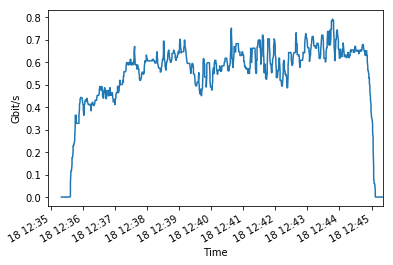

In [17]:
with PdfPages("latex_report/rolling.pdf") as pp:
    ax = rolling.plot()
    #ax.set_ybound(0, 1)
    ax.set_ylabel("Gbit/s")
    ax.set_xlabel("Time")
    pp.savefig()

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts)

ModuleNotFoundError: No module named 'pandas.plotting'

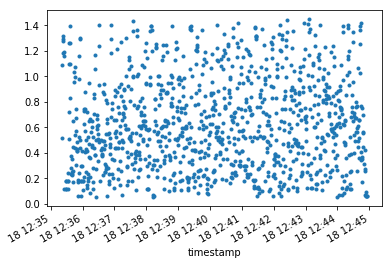

In [466]:
ax = df[df['gbit/s'] >= 0.05]['gbit/s'].plot(style='.', label='series')

Text(0.5,0,'Gbit/s')

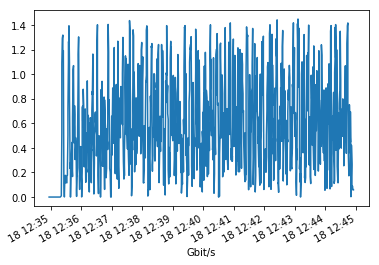

In [442]:
ax = df['gbit/s'].plot.kde()
ax.set_xlabel("Gbit/s")

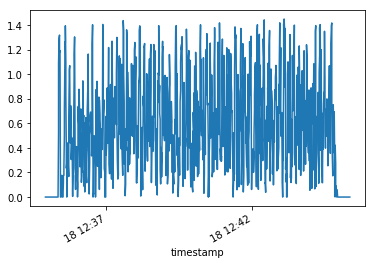

In [473]:
ax = ts.plot(label='series')

In [29]:
with open("runtimes.hdfs", "r") as fp:
    hdfs_runtimes = pandas.read_csv(fp, sep=";", header=None)
hdfs_runtimes

,0
0,3520.700000
1,3521.011254
2,3521.389005
3,3550.877396
4,3543.067071
5,3533.288691
6,3525.899639
7,3511.705611
8,3512.386863
9,3504.606011


In [30]:
hdfs_runtimes.sem()[0]

4.1392549731178949

In [31]:
hdfs_runtimes.mean()[0]

3524.040989221226

In [33]:
with open("sizes", "r") as fp:
    scaling_runtimes = pandas.read_csv(fp, sep=";", header=None,
                                      names=["Nr workers", "Runtime (s)"])
scaling_runtimes = scaling_runtimes.set_index("Nr workers")

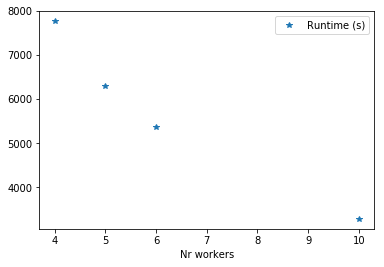

In [35]:
with PdfPages("latex_report/scaling.pdf") as pp:
    scaling_runtimes.plot(style="*")
    pp.savefig()